# Proyecto ETL
#### Grupo 1:  Gledson - Eva - Sara - Rubén - Luis Q

### - - Importación de módulos y librerías - -

In [4]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

import os
import locale

from datetime import datetime
from pprint import pprint

#  Se establece la configuración regional
configuracion_local = locale.setlocale(locale.LC_ALL, ("es_ES", "UTF-8"))

# Se toma el TOKEN de identificación para AirTable
TOKEN =  os.getenv("AIRTABLE_TOKEN")

# Definir la base de AirTable donde se subirán los datos
BASE_ID = ""

BASE_ID = "appOnz4LtIdKAOYfo"

print (f"Se establece la configuración regional a {configuracion_local}")

Se establece la configuración regional a es_ES.UTF-8


# Extracción de datos

Se definen las funciónes auxiliares para la extracción

In [5]:
# Función principal de extracción de datos
def extrae_datos_meneos (lista_meneos, año_busqueda):
    datos = []
    continuar = True
    for meneo in lista_meneos:
        dicc_aux = {}
        
        # Se obtiene en primer lugar el año
        try:
            fecha_pub = meneo.find("div", class_="news-submitted").find_all("span", class_="ts")[1].text.split(" ")[0]
            año = datetime.strptime(fecha_pub,"%d/%m/%Y").year if len(fecha_pub) > 5 else 2024
        except:
            año = False
        
        # Si el año detectado es igual que el año buscado, se continúa con la importación
        if año == año_busqueda:
            ###################################    Titular    ####################################################################
            try:
                dicc_aux["Titular"] = meneo.find("h2").text.replace("\n", " ").strip()
            except:
                dicc_aux["Titular"] = np.nan

            ###################################    Entradilla    ###################################################################
            try:
                dicc_aux["Entradilla"] = meneo.find("div", class_="news-content").text.replace("\n", " ").strip()
            except:
                dicc_aux["Entradilla"] = np.nan
                
            ###################################   Comunidad (Temática) ############################################################
            try:
                dicc_aux["Comunidad"] = meneo.find("a", class_="subname").text.strip()
            except:
                dicc_aux["Comunidad"] = np.nan

            ###################################    Usuario  ######################################################################
            try:
                dicc_aux["Usuario"] = meneo.find("div", class_="news-submitted").find("img")["alt"].strip()
            except:
                dicc_aux["Usuario"] = np.nan

            ###################################    Medio    ######################################################################
            try:
                dicc_aux["Medio"] = meneo.find("span", class_="showmytitle").text.strip()
            except:            
                dicc_aux["Medio"] = "meneame.net"

            ###################################    URL    ######################################################################
            try:
                dicc_aux["URL"] = "https://www.meneame.net" + meneo.find("a", class_="comments")["href"].strip()
            except:            
                dicc_aux["URL"] = np.nan

            ###################################    Fechas    ######################################################################    
            try:
                fechas = meneo.find("div", class_="news-submitted").find_all("span", class_="ts")
                dicc_aux["Enviado"] = fechas[0].text.strip()
                dicc_aux["Publicado"] = fechas[1].text.strip()
            except:
                dicc_aux["Enviado"] = np.nan
                dicc_aux["Publicado"] = np.nan

            ###################################    Meneos    ######################################################################
            try:
                dicc_aux["Meneos"] = meneo.find("div", class_="votes").find("a").text.strip()
            except:
                dicc_aux["Meneos"] = np.nan

            ###################################    Click    ######################################################################
            try:
                dicc_aux["Clicks"] = meneo.find("div", class_="clics").find("span").text.strip()
            except:
                dicc_aux["Clicks"] = np.nan

            ###################################    Positivos    ###################################################################
            try:
                dicc_aux["Positivos"] = meneo.find("span", class_="positive-vote-number").text.strip()
            except:
                dicc_aux["Positivos"] = np.nan

            ###################################    Votos Anónimos    ##############################################################
            try:
                dicc_aux["Anonimos"] = meneo.find("span", class_="anonymous-vote-number").text.strip()
            except:
                dicc_aux["Anonimos"] = np.nan

            ###################################    Votos Negativos    ##############################################################
            try:
                dicc_aux["Negativos"] = meneo.find("span", class_="negative-vote-number").text.strip()
            except:
                dicc_aux["Negativos"] = np.nan

            ###################################    Número comentarios    ###########################################################
            try:
                dicc_aux["Comentarios"] = meneo.find("a", class_="comments")["data-comments-number"].strip()
            except:
                dicc_aux["Comentarios"] = np.nan

            ###################################    Karma    ########################################################################
            try:
                dicc_aux["Karma"] = meneo.find("span", class_="karma-number").text.strip()
            except:
                dicc_aux["Karma"] = np.nan

            datos.append(dicc_aux)

        # Si se ha terminado el año buscado se detendrá la importación
        elif año < año_busqueda:
            continuar = False

    return [datos, continuar]

# Función para el cálculo de la pagina de inicio de extracción de datos del año elegido
def busca_pagina_inicio (año_elegido, total_paginas):
    # Se define un diccionario con las páginas de fin e inicio de cada año (obtenido manualmente)
    num_pagina_año = {"2005": [10906,10878], "2006" : [10878,10442], "2007" : [10442,9759], "2008" : [9759,8981],
                    "2009" : [8981,8196], "2010" : [8196,7499], "2011" : [7499,6782], "2012" : [6782,6149],
                    "2013" : [6149,5623], "2014" : [5623,5101], "2015" : [5101,4609], "2016" : [4609,4214],
                    "2017" : [4214,3774], "2018" : [3774,3230], "2019" : [3230,2733], "2020" : [2733,2058],
                    "2021" : [2058,1409], "2022" : [1409,740], "2023" : [740,139]}

    lista_a = []
    for i in num_pagina_año.keys():
        # Se obtiene el número de páginas de cada año, este número es invariable ya que no pueden añadirse noticias a un año ya pasado
        lista_a.append([i,num_pagina_año[i][0] - num_pagina_año[i][1]])

    # Se crea un DataFrame con esta información
    df_pags_año = pd.DataFrame(columns=["año", "cantidad"], data=lista_a)
    df_pags_año.set_index("año", inplace=True)

    # Se añade la columna de acumulado para conocer el total de páginas a recorrer hasta cada año    
    df_pags_año["acumulado"] = df_pags_año["cantidad"].cumsum()

    # Con el total de páginas y el acumulado se calula la página de inicio 
    df_pags_año["pag_inicio"] = total_paginas - df_pags_año["acumulado"]

    # Se retorna la página de inicio para el año elegido con un margen de seguridad de 1 página
    return df_pags_año.loc[str(año_elegido),"pag_inicio"]-1

#### Bucle para el Web Scrapping  ####

In [6]:
URL_BASE = "https://old.meneame.net/"

lista_aux = []
contador_paginas = 0
continuar_ejecucion = True

# Se solicita el año para la extracción de datos
try:
    año = int(input(f"Introducir un año entre 2006 y {datetime.now().year-1}"))
    if año not in range(2006,datetime.now().year):
        año = datetime.now().year-1
        print("-"*73)      
        print(f" Año fuera de rango, se toma por defecto el último año finalizado ({año})")
        print("-"*73)
    else:
        print("-"*34)
        print(f" Extracción de datos del año {año}")
        print("-"*34)
except:
    año = datetime.now().year-1
    print("-"*69)
    print(f" Año incorrecto, se toma por defecto el último año finalizado ({año})")
    print("-"*69)

browser = webdriver.Chrome()
browser.get(f"{URL_BASE}")

# Se obtiene el número total de páginas de noticias y se calcula la página de inicio para el año elegido
total_paginas = int(BeautifulSoup(browser.page_source, "html.parser").find("div", class_="pages").find_all("a")[-2].text)
pagina = busca_pagina_inicio(año, total_paginas)

contador_pruebas = 0

try:
    while contador_pruebas < 10 and continuar_ejecucion == True:
        try:
            # Se solicita al navegador la apertura de la URL de la página
            browser.get(f"{URL_BASE}?page={pagina}")

            # Se obtiene el BeautifulSoup a partir del código fuente de la página
            Soup_pagina_meneos = BeautifulSoup(browser.page_source, "html.parser")

            # Se extrae el listado de noticias
            lista_meneos = Soup_pagina_meneos.find_all("div", class_="news-summary")

            # Se analiza el listado con la función de extracción
            resultado = extrae_datos_meneos(lista_meneos, año)
            
            # Se añaden los resultados de la extracción a una lista
            lista_aux.extend(resultado[0])

            # Se almacena el dato para la parada del bucle
            continuar_ejecucion = resultado[1]

            # Se aumenta el contador de páginas
            pagina += 1
            contador_paginas += 1
            contador_pruebas += 1
            print(f"Importada página {contador_paginas}  ", end="\r")
        except:
            print(f"Error en página {pagina}")
except:
    print("Ocurrido un error inesperado... ¿Estaba cargada la función?")

print("\n")
print(f" Total paginas procesadas: {contador_paginas}")
print(f" Total noticias importadas: {len(lista_aux)}")

browser.close()

----------------------------------
 Extracción de datos del año 2022
----------------------------------
Importada página 10  

 Total paginas procesadas: 10
 Total noticias importadas: 195


Creación del DataFrame con la lista de datos extraída y otro con los municipios para cruzar datos

In [7]:
df_municipios = pd.read_csv("Data/Municipios.csv", sep = ";")
df = pd.DataFrame(lista_aux)
df.head(1)

,Titular,Entradilla,Comunidad,Usuario,Medio,URL,Enviado,Publicado,Meneos,Clicks,Positivos,Anonimos,Negativos,Comentarios,Karma
0,El desafío,En Gran Bretaña se está escenificando mejor qu...,actualidad,Supercinexin,elterritoriodellince.blogspot.com,https://www.meneame.net/story/el-desafio-1,31/12/2022 18:38,31/12/2022 23:55,274,2196,106,168,20,16,419


# TRANSFORMACIÓN

##### Se definen funciones auxiliares

In [8]:
# Función de cálculo de franja horaria
def franja_horaria (fecha):
    hora = fecha.hour
    if hora in range(6, 12):
        return "Mañana"
    elif hora in range(12, 16):
        return "Mediodía"
    elif hora in range(16, 21):
        return "Tarde"
    elif hora in range(21, 24):
        return "Noche"
    elif hora in range(0, 6):
        return "Madrugada"
    
lista_municipios = tuple(df_municipios["Nombre1"])
lista_municipios2 = tuple(df_municipios["Nombre2"])

# Función de localización de municipio 
def funcion_municipios(x):    
    municipio_encontrado = "No encontrado"
    for municipio1, municipio2 in zip(lista_municipios,lista_municipios2):
        if municipio1 in x:            
            municipio_encontrado = municipio1
            break
        elif municipio2 in x:
            municipio_encontrado = municipio1
            break
    
    return municipio_encontrado

##### Se hacen cambios de tipo de dato

In [9]:
df['Enviado'] = pd.to_datetime(df['Enviado'], format="%d/%m/%Y %H:%M")
df['Publicado'] = pd.to_datetime(df['Publicado'], format="%d/%m/%Y %H:%M")
df[["Meneos", "Clicks", "Positivos", "Anonimos","Negativos", "Comentarios", "Karma"]] = df[["Meneos", "Clicks", "Positivos", "Anonimos","Negativos", "Comentarios", "Karma"]].astype("int64")

##### Se crean las columnas adicionales

In [10]:
# Para tiempo que le ha tomado a la noticia en ser publicada
df['Delay'] = df['Publicado'] - df['Enviado']

# Para la franja horaria, día de la semana y mes de la publicación en español (haciendo uso del locale) y trimestre
df["Franja Horaria"] = df["Publicado"].apply(franja_horaria)
df["Día de la Semana"] = df["Publicado"].apply(lambda x : x.strftime("%A").capitalize())
df["Mes"] = df["Publicado"].apply(lambda x : x.strftime("%B").capitalize())
trimestres = {1: "1er Trimestre", 2: "2do Trimestre", 3: "3er Trimestre", 4: "4to Trimestre"}
df['Trimestre'] = df['Publicado'].dt.quarter.map(trimestres)

# Para el municipio, buscamos primero por Titular
df["Municipio"] = df["Titular"].apply(funcion_municipios)

# Para los que no ha encontrado, buscamos también por Entradilla
indices = df[df["Municipio"] == "No encontrado"].index.to_list()
for i in indices:
    df.at[i, "Municipio"] = funcion_municipios(df.loc[i, "Entradilla"])

# Para la obtención de la provincia, latitud y longitud correspondientes al municipio encontrado    
df = df.merge(df_municipios[["Provincia","Longitud", "Latitud","Nombre1"]],
              left_on="Municipio", right_on="Nombre1",how="left").drop("Nombre1", axis=1)

# Se realiza el tratamiento de NaN's y cambios de tipo para preparación para la carga
df["Provincia"] = df["Provincia"].replace(np.nan, "No encontrado")
df["Longitud"] = df["Longitud"].str.replace(",", ".")
df["Latitud"] = df["Latitud"].str.replace(",", ".")
df[["Latitud", "Longitud"]] = df[["Latitud", "Longitud"]].astype("float64")
df["Longitud"] = df["Longitud"].replace(np.nan, 0)
df["Latitud"] = df["Latitud"].replace(np.nan, 0)

df['Enviado'] = df['Enviado'].astype("str")
df['Publicado'] = df['Publicado'].astype("str")
df['Delay'] = df['Delay'].astype("str")

# CARGA

Se definen las variables necesarias para la API de Airtable

In [11]:
airtable_base_url = "https://api.airtable.com/v0"

# Headers
headers = {"Authorization" : f"Bearer {TOKEN}",
           "Content-Type"  : "application/json"}

##  JSON de creación de tabla

Especifica los campos de la tabla, su tipo y el nombre de la tabla incluyendo el año elegido en la extracción

In [12]:
nombres_columnas = {"name" : f"Meneame_{año}",
        "description" : f"Listado de meneos de la portada general de {año}",
        "fields": [
            {
                "name" : "Titular",
                "type" : "singleLineText"
            },
            {
                "name" : "Entradilla",
                "type" : "multilineText"
            },            
            {
                "name" : "Comunidad",
                "type" : "singleSelect",
                "options" : {
                    "choices":[{                        
                        "name" : "politica"
                    },
                    {                        
                        "name" : "ciencia"
                    }
                    ]
                }
            },
            {
                "name" : "Usuario",
                "type" : "singleLineText"
            },
            {
                "name" : "Medio",
                "type" : "singleLineText"
            },
            {
                "name" : "URL",
                "type" : "url"
            },
            {
                "name" : "Enviado",
                "type" : "dateTime",
                "options": {
                    "timeZone" : "Europe/Madrid",
                    "dateFormat" : {
                        "format" : "YYYY-MM-DD",
                        "name": "iso"
                    },
                    "timeFormat" : {
                        "format": "HH:mm",
                        "name": "24hour"
                    }
                }
            },
            {
                "name" : "Publicado",
                "type" : "dateTime",
                "options": {
                    "timeZone" : "Europe/Madrid",
                    "dateFormat" : {
                        "format" : "YYYY-MM-DD",
                        "name": "iso"
                    },
                    "timeFormat" : {
                        "format": "HH:mm",
                        "name": "24hour"
                    }
                }
            },            
            {
                "name" : "Meneos",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },
            {
                "name" : "Clicks",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },
            {
                "name" : "Positivos",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },
            {
                "name" : "Anonimos",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },
            {
                "name" : "Negativos",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },
            {
                "name" : "Comentarios",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },
            
            {
                "name" : "Karma",
                "type" : "number",
                "options" : {
                    "precision" : 0
                }
            },            
            {
                "name" : "Delay",
                "type" : "duration",
                "options" : {
                    "durationFormat" : "h:mm"
                }
            },
            {
                "name" : "Franja Horaria",
                "type" : "singleLineText"
            },
            {
                "name" : "Día de la Semana",
                "type" : "singleLineText"
            },
            {
                "name" : "Mes",
                "type" : "singleLineText",
            },
            {
                "name" : "Trimestre",
                "type" : "singleLineText"
            },
            {
                "name" : "Municipio",
                "type" : "singleLineText"
            },
            {
                "name" : "Provincia",
                "type" : "singleLineText"
            },
            {
                "name" : "Longitud",
                "type" : "number",
                "options" : {
                    "precision" : 8
                }
            },
            {
                "name" : "Latitud",
                "type" : "number",
                "options" : {
                    "precision" : 8
                }
            }            
        ]
        }

### Se realiza el request de creación de la tabla

In [13]:
endpoint_crea_tabla = f"https://api.airtable.com/v0/meta/bases/{BASE_ID}/tables"
    
response = requests.post(url = endpoint_crea_tabla, json= nombres_columnas, headers = headers)

print(f"endpoint: {response.url}")
# print(f"response: {response.status_code}")

if response.status_code == 200:
    print("-"*60)
    print("Tabla creada con éxito. ID: ", end="")
    pprint(response.json()["id"], sort_dicts = False)
    print("Nombre tabla: ", end="")
    pprint(response.json()["name"], sort_dicts = False)
    print("-"*60)
else:
    print(f"Error en la creación de tabla. Response status code: {response.status_code}")

# Se obtiene el ID de la tabla recién creada
try:
    TABLE_ID = response.json()["id"]
except:
    print(f"No se puede obtener el ID de la tabla Meneame_{año} porque ya existe una tabla con ese nombre.")
    # Se utiliza el nombre de la tabla como identificador
    TABLE_ID = f"Meneame_{año}"

endpoint: https://api.airtable.com/v0/meta/bases/appOnz4LtIdKAOYfo/tables
------------------------------------------------------------
Tabla creada con éxito. ID: 'tblA6xnBRNi1PNZGF'
Nombre tabla: 'Meneame_2022'
------------------------------------------------------------


### Se realiza el bucle de carga a Airtable

In [14]:

# Endpoint con la base definida y el ID de la tabla obtenido al momento de la creación
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

datos_json = [{"fields" : df.iloc[i, :].to_dict()} for i in range(df.shape[0])]
errores = {"Numero" : 0, "Bloques" : []}

print ("-" *36)    
print(f" Total de registros a cargar: {df.shape[0]}")
print ("-" *36)

for i in range(0, df.shape[0], 10):
    data = {"records" : datos_json[i : i + 10],
            "typecast": True}
    
    response = requests.post(url = endpoint, json = data, headers = headers)    
    print(f" Bloque de registros del {i}     al {i+10 if i+10 < df.shape[0] else i+(df.shape[0] - i)}      => Response status code: {response.status_code}", end="\r")
    
    if response.status_code != 200:
        errores["Numero"] += 1
        errores["Bloques"].append(f"Índices de {i} a {i+10}")

if errores["Numero"] > 0:
    print ("\n")
    print ("-" *39)    
    print(f" Ha habido {errores['Numero']} errores en la carga")
    for i in range(len(errores["Bloques"])):
        print(errores["Bloques"][i])
    print ("-" *39)
else:
    print ("\n")
    print ("-" *25)    
    print(f" Sin errores en la carga")
    print ("-" *25)

------------------------------------
 Total de registros a cargar: 196
------------------------------------
 Bloque de registros del 190     al 196      => Response status code: 200

-------------------------
 Sin errores en la carga
-------------------------


# Descarga desde AirTable

In [15]:
# Se descargan los registros
params = {"offset" : None}
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

df_airtable = pd.DataFrame()
contador_descarga = 0
while params.get("offset") != None or df_airtable.shape[0] == 0:
    response = requests.get(url = endpoint, headers = headers, params = params)    
    print(f" Bloque descarga de {contador_descarga}     a {contador_descarga + 100}     : Response: {response.status_code} => URL: {response.url}", end="\r")
    contador_descarga += 100
    params["offset"] = response.json().get("offset")
    
    df_airtable = pd.concat([df_airtable, pd.json_normalize(response.json()["records"])], ignore_index = True)    
    
    if df_airtable.shape[0] == 0:
        print("\n")
        print ("-" *39)   
        print(f" No existen registros para descargar")
        print ("-" *39)
        break

if df_airtable.shape[0] != 0:
    df_airtable.columns = [x.split(".")[1] if "." in x else x for x in df_airtable.columns]
    df_airtable.drop(["id", "createdTime"], axis=1, inplace=True)

print("\n")
print ("-" *39)    
print(f" Total de registros descargados: {df_airtable.shape[0]}")
print ("-" *39)

 Bloque descarga de 100     a 200     : Response: 200 => URL: https://api.airtable.com/v0/appOnz4LtIdKAOYfo/tblA6xnBRNi1PNZGF?offset=itrQLuwLtGPBn8S1r%2FrecUPZPKtk9WN7yMG

---------------------------------------
 Total de registros descargados: 196
---------------------------------------


In [16]:
df_airtable.head()

,Titular,Entradilla,Comunidad,Usuario,Medio,URL,Enviado,Publicado,Meneos,Clicks,...,Karma,Delay,Franja Horaria,Día de la Semana,Mes,Trimestre,Municipio,Provincia,Longitud,Latitud
0,El sobreaprendizaje es vital para una aprendiz...,El sobreaprendizaje aumenta la memoria y la co...,ciencia,doyou,mcguffineducativo.es,https://www.meneame.net/story/sobreaprendizaje...,2022-12-27T08:27:00.000Z,2022-12-27T14:25:00.000Z,235,2013,...,350,1288800,Mediodía,Martes,Diciembre,4to Trimestre,No encontrado,No encontrado,0.000000,0.000000
1,La menor de la discoteca Waka Sabadell denunci...,La menor asegura “no recordar nada” de lo suce...,actualidad,sesky,lavanguardia.com,https://www.meneame.net/story/menor-discoteca-...,2022-12-28T10:33:00.000Z,2022-12-28T12:50:00.000Z,246,5032,...,387,493200,Mediodía,Miércoles,Diciembre,4to Trimestre,Sabadell,Barcelona,2.107790,41.546959
2,"""Que se vaya Putin no es la solución; dentro d...",El historiador y profesor Francisco Veiga publ...,actualidad,cocolisto,elconfidencial.com,https://www.meneame.net/story/vaya-putin-no-so...,2022-12-27T23:09:00.000Z,2022-12-28T09:15:00.000Z,213,2102,...,411,2181600,Mañana,Miércoles,Diciembre,4to Trimestre,No encontrado,No encontrado,0.000000,0.000000
3,Cinco máquinas que han cambiado el mundo de la...,"Ideas, iniciativas empresariales, descuidos cl...",tecnología,Arariel,pixartprinting.es,https://www.meneame.net/story/cinco-maquinas-h...,2022-12-27T08:44:00.000Z,2022-12-28T00:20:00.000Z,89,2682,...,423,3369600,Madrugada,Miércoles,Diciembre,4to Trimestre,No encontrado,No encontrado,0.000000,0.000000
4,La justicia peruana ordena derribar el polémic...,"El conocido ""muro de la vergüenza"" que se erig...",politica,Ripio,es.noticias.yahoo.com,https://www.meneame.net/story/justicia-peruana...,2022-12-30T08:39:00.000Z,2022-12-30T16:30:00.000Z,359,4385,...,395,1695600,Tarde,Viernes,Diciembre,4to Trimestre,María,Almería,-2.164798,37.711554


# VISUALIZACIONES

In [24]:
import plotly.express as px
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

### Nube de palabras con los medios más enviados

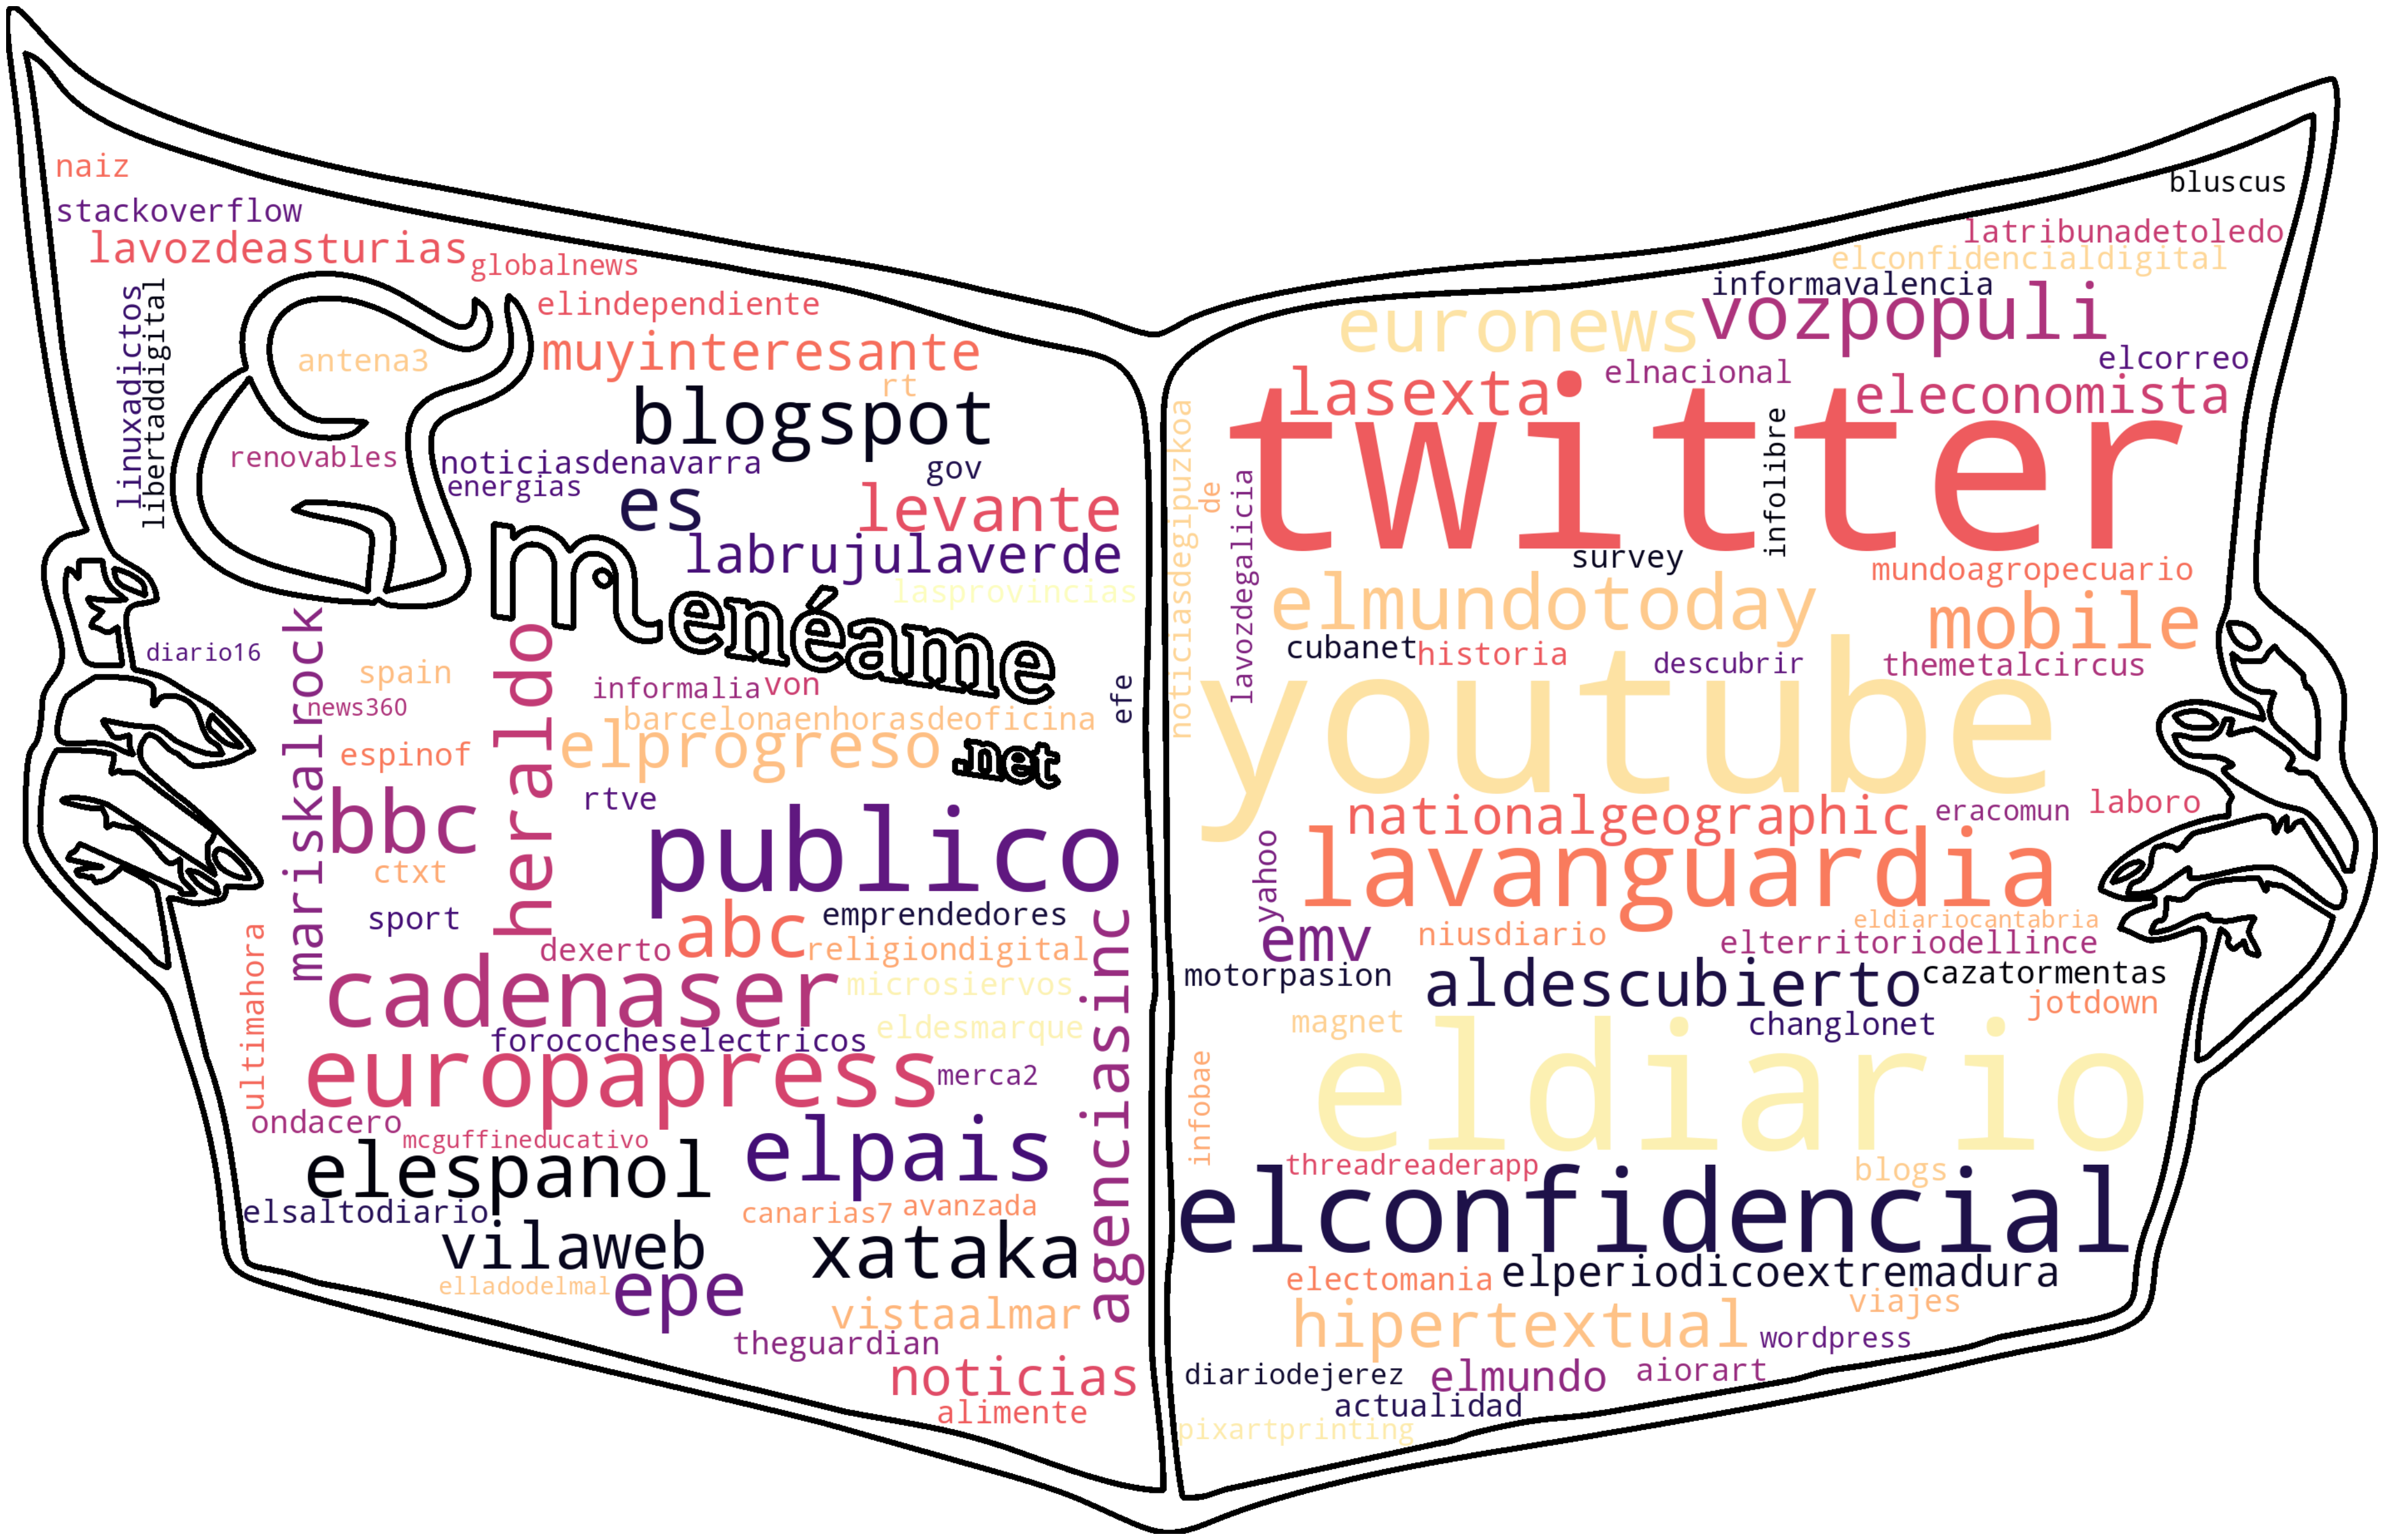

In [26]:
news_medios_mask = np.array(Image.open("Data/newspaper.png"))

df_Medios = pd.DataFrame(columns=["Medio"], data=df["Medio"])
df_Medios["Medio"] = df_Medios["Medio"].apply(lambda x : x.rsplit(".", maxsplit=1)[0])

Medios_WordCloud = WordCloud(background_color = "white",
                  max_words        = 1000,
                  mask             = news_medios_mask,
                  contour_width    = 10,
                  colormap        = "magma",
                  contour_color    = "black")

Medios_WordCloud.generate(df_Medios["Medio"].to_csv(header=None, index=None))

plt.subplots(figsize = (50, 50))

plt.imshow(Medios_WordCloud, interpolation ="bilinear")
plt.axis("off")
plt.show()

### Cantidad de meneos por comunidad

In [18]:
fig = px.histogram(data_frame=df_airtable,
             x="Comunidad",
             color="Comunidad",
             text_auto=True,
             title="Meneos por Comunidad"
             )

fig.update_xaxes(categoryorder = "total descending")
fig.update_traces(textposition = "outside")

### Cantidad de meneos por medio

In [19]:

df_cant_medio = df_airtable.groupby("Medio", as_index=False).count().sort_values("Titular", ascending=False)[["Medio","Titular"]].head()
df_cant_medio.rename(columns={"Titular":"Número Noticias"}, inplace=True)

fig = px.bar(df_cant_medio,
             x="Medio",
             y="Número Noticias",
             color="Medio",
             text_auto=True
             )
fig.update_traces(textposition = "outside")

fig

### Delay entre fecha de envío y fecha de publicación por día de la semana y franja horaria

In [21]:

df_airtable["Delay(h)"] = df_airtable["Delay"]/3600
df_Dia_Franja_Delay = df_airtable[["Día de la Semana", "Franja Horaria", "Delay(h)"]].groupby(["Día de la Semana", "Franja Horaria"], as_index=False).mean(numeric_only=True).round(2)

fig = px.sunburst(df_Dia_Franja_Delay, path=['Día de la Semana', 'Franja Horaria'], values='Delay(h)', color='Franja Horaria')

fig.update_traces(textinfo = "label+percent parent")

fig.show()

### Usuarios con más meneos acumulados por medio

In [31]:
px.treemap(data_frame       = df_airtable,
           values           = "Meneos",
           path             = ["Medio", "Usuario"]
           )

